In [49]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


import matplotlib.dates as mdates
import plotly.express as px
from datetime import date, timedelta
from sklearn.cluster import KMeans
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [50]:

path = '../input/coronavirusdataset/'


patient_data_path = path + 'patient.csv'
route_data_path = path + 'route.csv'
time_data_path = path + 'time.csv'


df_patient =pd.read_csv(patient_data_path)

df_route = pd.read_csv(route_data_path)
df_time = pd.read_csv(time_data_path)

In [51]:
df_patient.head()

,patient_id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
0,1,female,1984.0,China,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released
1,2,male,1964.0,Korea,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released
2,3,male,1966.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released
3,4,male,1964.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released
4,5,male,1987.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released


In [52]:
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7869 entries, 0 to 7868
Data columns (total 15 columns):
patient_id          7869 non-null int64
sex                 679 non-null object
birth_year          666 non-null float64
country             7869 non-null object
region              437 non-null object
disease             28 non-null float64
group               86 non-null object
infection_reason    154 non-null object
infection_order     36 non-null float64
infected_by         70 non-null float64
contact_number      53 non-null float64
confirmed_date      7869 non-null object
released_date       56 non-null object
deceased_date       36 non-null object
state               7869 non-null object
dtypes: float64(5), int64(1), object(9)
memory usage: 922.3+ KB


In [53]:
df_patient.describe()

,patient_id,birth_year,disease,infection_order,infected_by,contact_number
count,7869.000000,666.000000,28.0,36.000000,70.000000,53.000000
mean,3935.000000,1974.271772,1.0,4.277778,379.000000,67.849057
std,2271.728967,17.423250,0.0,12.032364,540.247528,177.723575
min,1.000000,1929.000000,1.0,1.000000,3.000000,0.000000
25%,1968.000000,1962.000000,1.0,1.000000,29.250000,3.000000
50%,3935.000000,1974.000000,1.0,2.000000,126.000000,17.000000
75%,5902.000000,1990.000000,1.0,3.000000,563.250000,45.000000
max,7869.000000,2018.000000,1.0,74.000000,2621.000000,1160.000000


In [54]:
df_patient.groupby('country').count()


,patient_id,sex,birth_year,region,disease,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
country,,,,,,,,,,,,,,
China,8,8,8,8,0,1,7,6,2,6,8,5,0,8
Korea,7860,670,657,428,27,85,147,30,68,47,7860,51,35,7860
Mongolia,1,1,1,1,1,0,0,0,0,0,1,0,1,1


In [55]:
df_patient.columns

Index(['patient_id', 'sex', 'birth_year', 'country', 'region', 'disease',
       'group', 'infection_reason', 'infection_order', 'infected_by',
       'contact_number', 'confirmed_date', 'released_date', 'deceased_date',
       'state'],
      dtype='object')

In [56]:
df_patient.isna().sum()


patient_id             0
sex                 7190
birth_year          7203
country                0
region              7432
disease             7841
group               7783
infection_reason    7715
infection_order     7833
infected_by         7799
contact_number      7816
confirmed_date         0
released_date       7813
deceased_date       7833
state                  0
dtype: int64

In [57]:
df_patient.birth_year.unique()

array([1984., 1964., 1966., 1987., 1991., 1957., 1992., 1995., 1971.,
       1980., 1977., 1982., 1999., 1983., 1978., 1960., 1973., 1962.,
       1946., 1968., 1989., 1938., 1952., 1959., 2009., 1996., 1994.,
       1972., 1963., 1943., 1951., 1974., 1948., 1944., 1961., 1945.,
       1990., 1986., 1970., 1998., 1981., 2000., 1997., 1965., 1955.,
       1956., 1979.,   nan, 1953., 1940., 1967., 1941., 1993., 1976.,
       1958., 1936., 1988., 1954., 1985., 1969., 2005., 1937., 1975.,
       2003., 2015., 1950., 2004., 1949., 2018., 1934., 2011., 1947.,
       1942., 2001., 1935., 1932., 1939., 2007., 1930., 1933., 2013.,
       1929.])

In [58]:
### we can add a new columns for age 

In [59]:
df_patient[df_patient['birth_year']<0] 


,patient_id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state


In [60]:

df_patient['birth_year'].isnull().count()


7869

In [61]:
df_patient['birth_year']=df_patient['birth_year'].fillna(np.nan,inplace=True)


In [62]:
## now forming age column 

df_patient['age'] = 2020 - df_patient['birth_year']  ## create an age column 



In [63]:
## now splitting the data into age groups

import math
def group_age(age):
    if age >= 0: # not NaN
        if age % 10 != 0:
            lower = int(math.floor(age / 10.0)) * 10
            upper = int(math.ceil(age / 10.0)) * 10 - 1
            return f"{lower}-{upper}"
        else:
            lower = int(age)
            upper = int(age + 9) 
            return f"{lower}-{upper}"
    return "Unknown"


df_patient["age_range"] = df_patient["age"].apply(group_age)


In [64]:
df_patient['age_range']

0       Unknown
1       Unknown
2       Unknown
3       Unknown
4       Unknown
         ...   
7864    Unknown
7865    Unknown
7866    Unknown
7867    Unknown
7868    Unknown
Name: age_range, Length: 7869, dtype: object

In [65]:
patient=df_patient

In [66]:
date_cols = ["confirmed_date", "released_date", "deceased_date"] ## into datetime format
for col in date_cols:
    patient[col] = pd.to_datetime(patient[col])

In [67]:
patient.head()

,patient_id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state,age,age_range
0,1,female,None,China,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaT,released,NaN,Unknown
1,2,male,None,Korea,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaT,released,NaN,Unknown
2,3,male,None,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaT,released,NaN,Unknown
3,4,male,None,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaT,released,NaN,Unknown
4,5,male,None,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaT,released,NaN,Unknown


In [68]:
patient.infected_by.unique()

array([  nan,    3.,    5.,    6.,   12.,    4.,   16.,   15.,   27.,
         83.,   29.,   20.,   31.,  136.,   40.,   56.,  126.,  113.,
        230.,   30.,  161.,  246.,  347.,  372.,  164.,  627.,  780.,
        188.,  794.,  835.,  335.,  938., 1251.,   44., 1532., 1252.,
       1768., 1177., 1257., 1247., 2621.,  121.])

In [69]:
patient["time_to_release_since_confirmed"] = patient["released_date"] - patient["confirmed_date"]
patient["time_to_death_since_confirmed"] = patient["deceased_date"] - patient["confirmed_date"]
patient["duration_since_confirmed"] = patient[["time_to_release_since_confirmed", "time_to_death_since_confirmed"]].min(axis=1)
patient["duration_days"] = patient["duration_since_confirmed"].dt.days
age_ranges = sorted(set([ar for ar in patient["age_range"] if ar != "Unknown"]))
patient["state_by_gender"] = patient["state"] + "_" + patient["sex"]
released = df_patient[df_patient.state == 'released']
isolated_state = df_patient[df_patient.state == 'isolated']
dead = df_patient[df_patient.state == 'deceased']


**Confirmed Cases**

In [70]:
clus=df_route.loc[:,['id','latitude','longitude']]
clus.head(10)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



,id,latitude,longitude
0,NaN,37.460459,126.440680
1,NaN,37.478832,126.668558
2,NaN,37.562143,126.801884
3,NaN,37.567454,127.005627
4,NaN,37.460459,126.440680
5,NaN,37.524978,127.027718
6,NaN,37.503359,127.049177
7,NaN,37.524669,127.015911
8,NaN,37.529200,127.032597
9,NaN,37.674192,126.776955


**Checking for number of cluster**

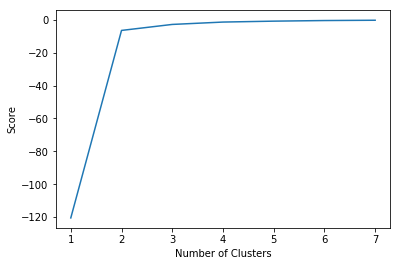

In [71]:
K_clusters = range(1,8)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df_route[['latitude']]
X_axis = df_route[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()



As in this graph, after 4 score go to constant value, so we will go with 4 clusters

**K-Mean Clusterning**

In [72]:
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(clus[clus.columns[1:3]])
clus['cluster_label'] = kmeans.fit_predict(clus[clus.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(clus[clus.columns[1:3]])

**Graphical representation of clusters**

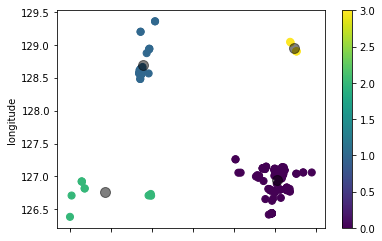

In [73]:
clus.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)


In [74]:
data = daily_count.resample('D').first().fillna(0).cumsum()
data = data[20:]
x = np.arange(len(data)).reshape(-1, 1)
y = data.values

**Regression Model**

In [75]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=[32, 32, 10], max_iter=50000, alpha=0.0005, random_state=26)
_=model.fit(x, y)

NameError: name 'x' is not defined

In [ ]:
test = np.arange(len(data)+7).reshape(-1, 1)
pred = model.predict(test)
prediction = pred.round().astype(int)
week = [data.index[0] + timedelta(days=i) for i in range(len(prediction))]
dt_idx = pd.DatetimeIndex(week)
predicted_count = pd.Series(prediction, dt_idx)

**Graphical representatoin of current confirmed and predicted confirmed**

In [ ]:
accumulated_count.plot()
predicted_count.plot()
plt.title('Prediction of Accumulated Confirmed Count')
plt.legend(['current confirmd count', 'predicted confirmed count'])
plt.show()

**Prophet**

**Making data ready for Prophet**

In [ ]:
prophet= pd.DataFrame(data)
prophet
pr_data = prophet.reset_index()
pr_data.columns = ['ds','y']
pr_data

**Model and prediction**

In [ ]:
m=Prophet()
m.fit(pr_data)
future=m.make_future_dataframe(periods=365)
forecast=m.predict(future)
forecast

**Graphical Representation of Prediction**

In [ ]:
fig = plot_plotly(m, forecast)
py.iplot(fig) 

fig = m.plot(forecast,xlabel='Date',ylabel='Confirmed Count')


In [ ]:
figure=m.plot_components(forecast)


**Autoregressive integrated moving average(Arima)**

**Making data ready for Arima**

In [ ]:
confirm_cs = prophet.cumsum()
arima_data = confirm_cs.reset_index()
arima_data.columns = ['confirmed_date','count']
arima_data

** Model and prediction**

In [ ]:
model = ARIMA(arima_data['count'].values, order=(1, 2, 1))
fit_model = model.fit(trend='c', full_output=True, disp=True)
fit_model.summary()

**Graphical Representation for Prediction**

In [ ]:
fit_model.plot_predict()
plt.title('Forecast vs Actual')
pd.DataFrame(fit_model.resid).plot()


Forcast for next 6 days

In [ ]:
forcast = fit_model.forecast(steps=6)
pred_y = forcast[0].tolist()
pd.DataFrame(pred_y)

**LSTM**

In [ ]:
dataset = pd.DataFrame(data)
dataset.columns = ['Confirmed']
dataset.head()

In [ ]:
data = np.array(dataset).reshape(-1, 1)
train_data = dataset[:len(dataset)-5]
test_data = dataset[len(dataset)-5:]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)
n_input =5
n_features =1
                             
generator = TimeseriesGenerator(scaled_train_data,scaled_train_data, length=n_input, batch_size=1)

lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (n_input, n_features)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50, return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units = 1))
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
lstm_model.fit(generator, epochs = 30)

In [ ]:
lstm_model.history.history.keys()


In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize = (30,4))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0,100,1))
plt.plot(range(len(losses_lstm)), losses_lstm)

In [ ]:
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)


In [ ]:
prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
prediction.head()